In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

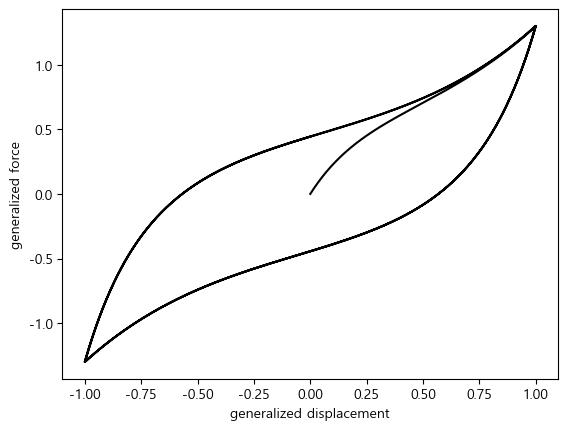

In [2]:
# APPLIED DISPLACEMENT TIME HISTORY
dt = 0.001
t = np.arange(0, 3 + dt, dt)
a0 = 1
fr = 1
u = a0 * np.sin(2 * np.pi * fr * t[:len(t)])
v = 2 * np.pi * fr * a0 * np.cos(2 * np.pi * fr * t[:len(t)])
n = len(u)

# INITIAL SETTINGS
# Set the four model parameters
ka = 5.0
kb = 0.5
alfa = 5.0
beta = 1.0
# Compute the internal model parameters
u0 = -(1 / (2 * alfa)) * np.log(10 ** -20 / (ka - kb))
f0 = ((ka - kb) / (2 * alfa)) * (1 - np.exp(-2 * alfa * u0))
# Initialize the generalized force vector
f = np.zeros(n)

# CALCULATIONS AT EACH TIME STEP
for i in range(1, n):
    # Update the history variable
    uj = u[i-1] + 2*u0*np.sign(v[i]) + np.sign(v[i])*(1/alfa)*np.log(np.abs(np.sign(v[i])*(alfa/(ka-kb))*(-2*beta*u[i-1]+np.exp(beta*u[i-1])-np.exp(-beta*u[i-1])+kb*u[i-1]+np.sign(v[i])*((ka-kb)/alfa)*np.exp(-2*alfa*u0)+np.sign(v[i])*f0-f[i-1])))
    # Evaluate the generalized force at time t
    if (np.sign(v[i])*uj-2*u0 < np.sign(v[i])*u[i]) or (np.sign(v[i])*u[i] < np.sign(v[i])*uj):
        f[i] = -2*beta*u[i] + np.exp(beta*u[i]) - np.exp(-beta*u[i]) + kb*u[i] - np.sign(v[i])*((ka-kb)/alfa)*(np.exp(-alfa*(np.sign(v[i])*(u[i]-uj)+2*u0))-np.exp(-2*alfa*u0)) + np.sign(v[i])*f0
    else:
        f[i] = -2*beta*u[i] + np.exp(beta*u[i]) - np.exp(-beta*u[i]) + kb*u[i] + np.sign(v[i])*f0

# PLOT
plt.figure()
plt.plot(u, f, 'k')
plt.xlabel('generalized displacement')
plt.ylabel('generalized force')
plt.show()


In [3]:
from sklearn.preprocessing import StandardScaler

In [4]:
sc = StandardScaler()

In [5]:
import keras
from keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM
from keras import optimizers

In [6]:
total = pd.DataFrame()

In [7]:
total['u'] = u
total['time'] = t
total['f'] = f


In [8]:
total

,u,time,f
0,0.000000e+00,0.000,0.000000
1,6.283144e-03,0.001,0.017059
2,1.256604e-02,0.002,0.033687
3,1.884844e-02,0.003,0.049898
4,2.513010e-02,0.004,0.065705
...,...,...,...
2996,-2.513010e-02,2.996,0.430554
2997,-1.884844e-02,2.997,0.433910
2998,-1.256604e-02,2.998,0.437259
2999,-6.283144e-03,2.999,0.440601


In [9]:
x = total.iloc[:,0:2]
y = total.f

In [10]:
x_tf = tf.convert_to_tensor(x.values)
y_tf = tf.convert_to_tensor(y)

In [11]:
x_tr = x_tf[:2000]
x_te = x_tf[2000:]
y_tr = y_tf[:2000]
y_te = y_tf[2000:]

----
## LSTM

In [55]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(64, input_shape=(2, 1), return_sequences=True))
model.add(tf.keras.layers.LSTM(32))
model.add(tf.keras.layers.Dense(1))

In [56]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 2, 64)             16896     
                                                                 
 lstm_3 (LSTM)               (None, 32)                12416     
                                                                 
 dense_14 (Dense)            (None, 1)                 33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________


In [57]:
adam = optimizers.Adam(lr=0.01)

In [58]:
model.compile(loss = 'mse', optimizer = adam, metrics = 'mse')

In [59]:
history = model.fit(x_tr, y_tr, epochs = 500)

Epoch 1/500
63/63 [==============================] - 3s 2ms/step - loss: 0.2092 - mse: 0.2092
Epoch 2/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1341 - mse: 0.1341
Epoch 3/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1197 - mse: 0.1197
Epoch 4/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1056 - mse: 0.1056
Epoch 5/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1073 - mse: 0.1073
Epoch 6/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1096 - mse: 0.1096
Epoch 7/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1045 - mse: 0.1045
Epoch 8/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1027 - mse: 0.1027
Epoch 9/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1024 - mse: 0.1024
Epoch 10/500
63/63 [==============================] - 0s 2ms/step - loss: 0.1026 - mse: 0.1026
Epoch 11/500
63/63 [==============================] - 0s 2m

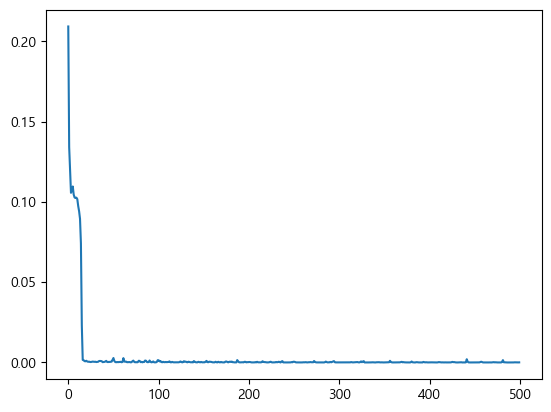

In [60]:
plt.plot(history.history['loss'])

In [61]:
pred = model.predict(x_te)

32/32 [==============================] - 1s 760us/step


In [62]:
pred = pred.reshape(-1,1)

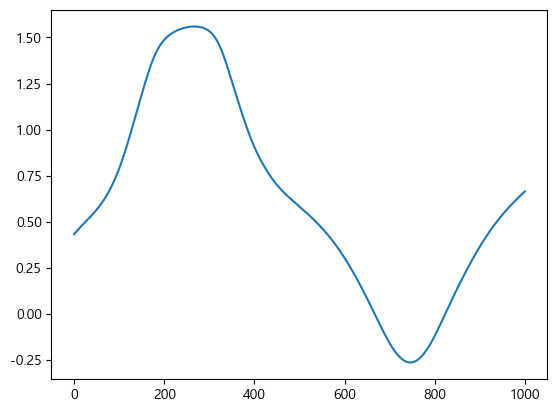

In [63]:
plt.plot(pred)

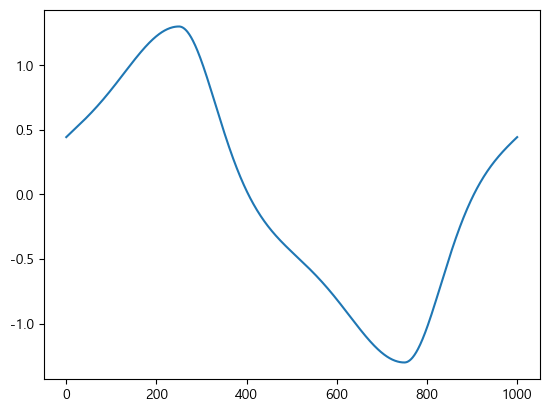

In [64]:
plt.plot(y_te)

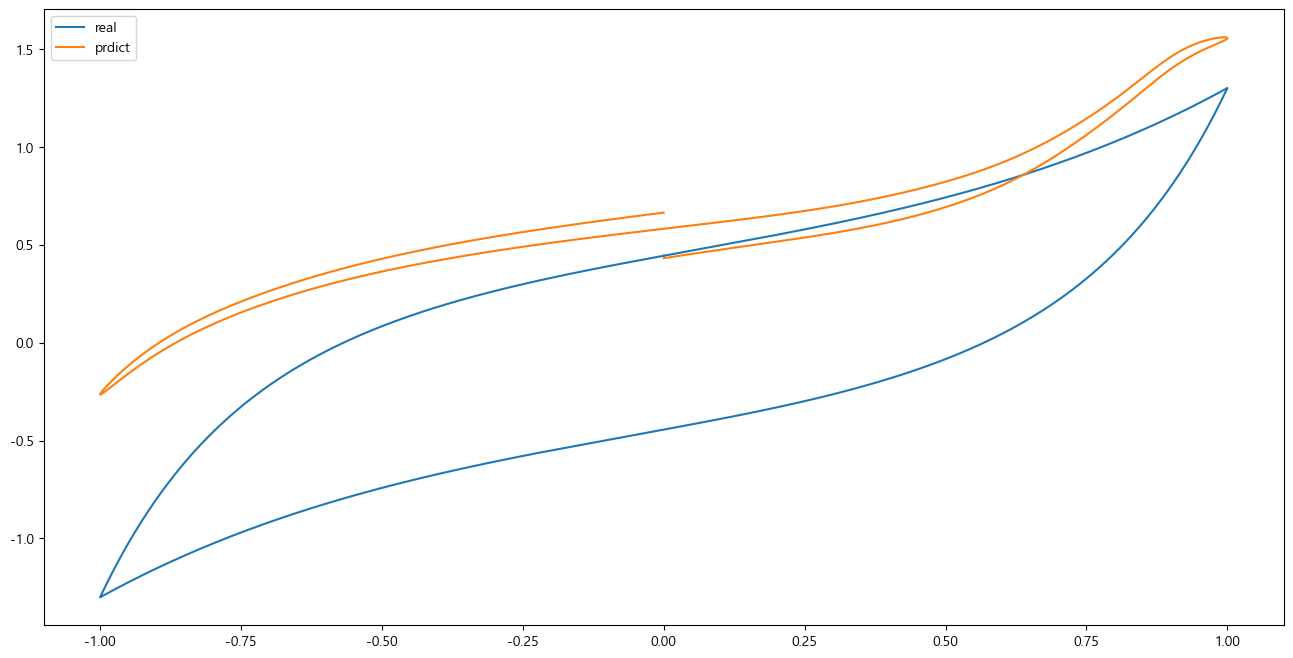

In [65]:
plt.figure(figsize=(16,8))
plt.plot(x.iloc[2000:,0], y.iloc[2000:], label = 'real')
plt.plot(x.iloc[2000:,0], pred, label = 'prdict')
plt.legend()
plt.show()

----
## DNN

In [47]:
model_2 = Sequential()
model_2.add(tf.keras.layers.Dense(32, input_shape=(2,)))
model_2.add(tf.keras.layers.Dense(64, activation='relu'))
model_2.add(tf.keras.layers.Dense(128, activation='relu'))
model_2.add(tf.keras.layers.Dense(64, activation='sigmoid'))
model_2.add(tf.keras.layers.Dense(1))

model_2.compile(loss = 'mse', optimizer = adam)

In [48]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 32)                96        
                                                                 
 dense_10 (Dense)            (None, 64)                2112      
                                                                 
 dense_11 (Dense)            (None, 128)               8320      
                                                                 
 dense_12 (Dense)            (None, 64)                8256      
                                                                 
 dense_13 (Dense)            (None, 1)                 65        
                                                                 
Total params: 18,849
Trainable params: 18,849
Non-trainable params: 0
_________________________________________________________________


In [49]:
dnn = model_2.fit(x_tr, y_tr, epochs=500)

Epoch 1/500
63/63 [==============================] - 0s 629us/step - loss: 0.3255
Epoch 2/500
63/63 [==============================] - 0s 597us/step - loss: 0.1256
Epoch 3/500
63/63 [==============================] - 0s 613us/step - loss: 0.1413
Epoch 4/500
63/63 [==============================] - 0s 605us/step - loss: 0.1143
Epoch 5/500
63/63 [==============================] - 0s 613us/step - loss: 0.1091
Epoch 6/500
63/63 [==============================] - 0s 613us/step - loss: 0.1155
Epoch 7/500
63/63 [==============================] - 0s 629us/step - loss: 0.1028
Epoch 8/500
63/63 [==============================] - 0s 597us/step - loss: 0.1038
Epoch 9/500
63/63 [==============================] - 0s 694us/step - loss: 0.1094
Epoch 10/500
63/63 [==============================] - 0s 645us/step - loss: 0.0948
Epoch 11/500
63/63 [==============================] - 0s 629us/step - loss: 0.0762
Epoch 12/500
63/63 [==============================] - 0s 629us/step - loss: 0.0239
Epoch 13/500


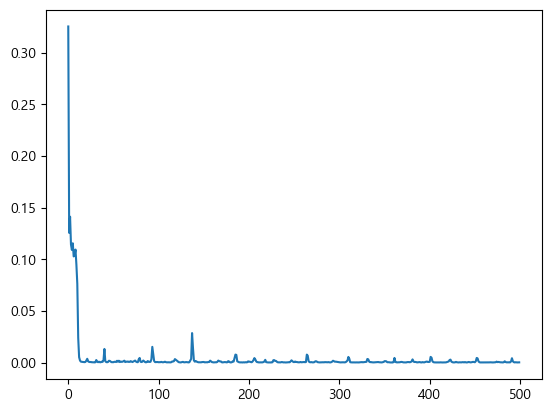

In [50]:
plt.plot(dnn.history['loss'])

In [51]:
pred_2 = model_2.predict(x_te)

32/32 [==============================] - 0s 516us/step


In [52]:
pred_2 = pred_2.reshape(-1,1)

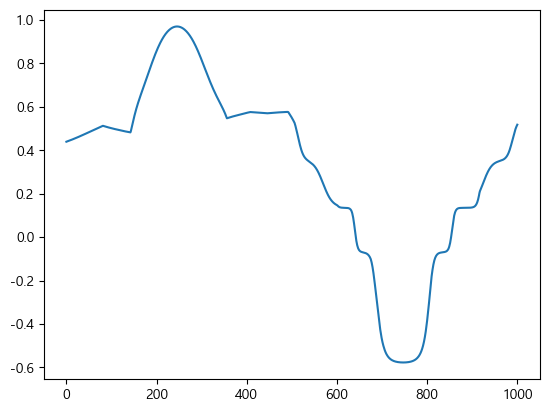

In [53]:
plt.plot(pred_2)

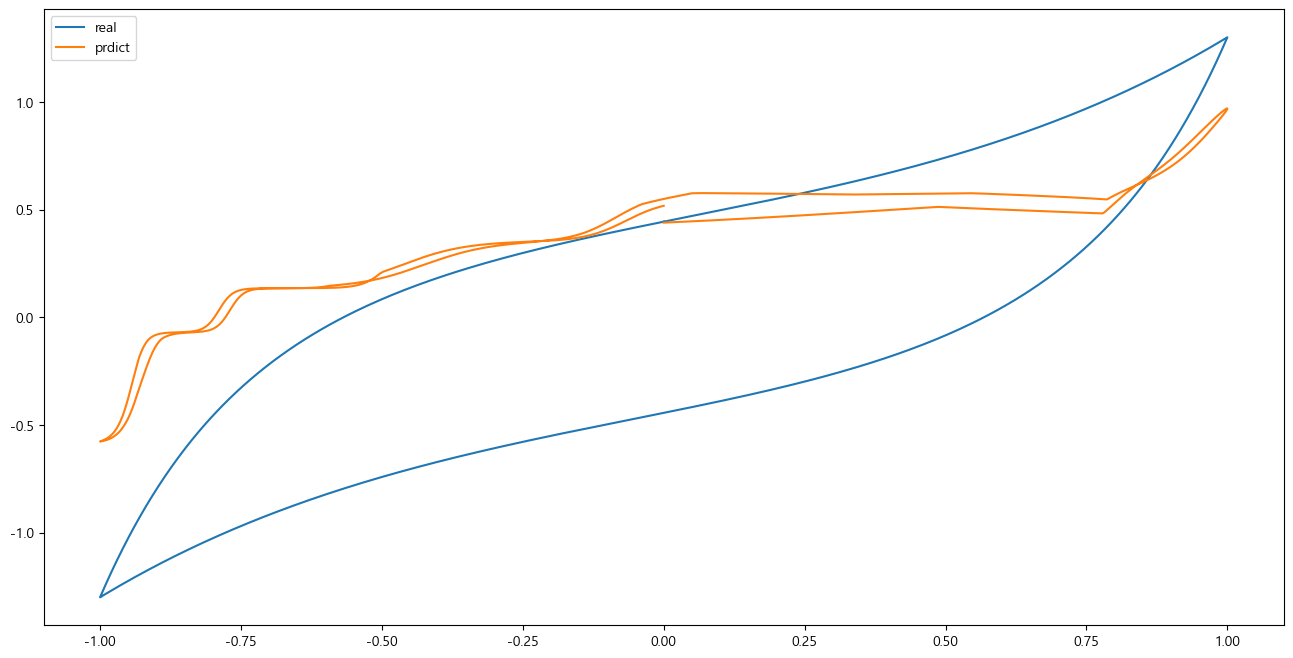

In [54]:
plt.figure(figsize=(16,8))
plt.plot(x.iloc[2000:,0], y.iloc[2000:], label = 'real')
plt.plot(x.iloc[2000:,0], pred_2, label = 'prdict')
plt.legend()
plt.show()

---
## PINN

In [30]:
x0, y0 = 0, 0
w = 0.5
mu = 0.1

In [31]:
from scipy.integrate import odeint
from math import *
from tqdm import tqdm

In [32]:
def xt(x, t):
    return -2*beta*x[1] + np.exp(beta*x[1]) - np.exp(-beta*x[1]) + kb*x[1] - np.sign(v[i])*((ka-kb)/alfa)*(np.exp(-alfa*(np.sign(v[i])*(x[1]-uj)+2*u0))-np.exp(-2*alfa*u0)) + np.sign(v[i])*f0

In [93]:
class PINN(tf.keras.Model):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.hidden_layer_1 = tf.keras.layers.Dense(units=256, activation=tf.nn.tanh)
        self.hidden_layer_2 = tf.keras.layers.Dense(units=128, activation=tf.nn.tanh)
        # self.hidden_layer_3 = tf.keras.layers.Dense(units=64, activation=tf.nn.tanh)
        self.output_layer = tf.keras.layers.Dense(units=output_dim)

    def call(self, inputs):
        x = self.hidden_layer_1(inputs)
        x = self.hidden_layer_2(x)
        output = self.output_layer(x)
        return output

In [100]:
model = PINN(2, 1)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

ephoch = 500

import sympy as sp

f = -2*beta*u + sp.exp(beta*u) - sp.exp(-beta*u) + kb*u - sp.sign(v)*((ka-kb)/alfa)*(sp.exp(-alfa*(sp.sign(v)*(u-uj)+2*u0))-sp.exp(-2*alfa*u0)) + sp.sign(v)*f0


In [101]:
@tf.function
def compute_df_du(u, v, beta, kb, ka, alfa, u0, f0, uj):
    with tf.GradientTape() as tape:
        tape.watch(u)  
        f = -2*beta*u + tf.exp(beta*u) - tf.exp(-beta*u) + kb*u - tf.sign(v)*((ka-kb)/alfa)*(tf.exp(-alfa*(tf.sign(v)*(u-uj)+2*u0))-tf.exp(-2*alfa*u0)) + tf.sign(v)*f0

    df_du = tape.gradient(f, u)
    df_du = tf.cast(df_du, dtype=tf.float32)
    
    return df_du

In [102]:
def custom_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_true = tf.expand_dims(y_true, axis=-1)

    u, v = tf.split(x_tr, 2, axis=-1)  
    
    df_du = compute_df_du(u, v, beta, kb, ka, alfa, u0, f0, uj)
    df_du = tf.expand_dims(df_du, axis=-1)
    physics_loss = tf.reduce_mean(tf.square(y_pred - df_du))

    data_loss = tf.reduce_mean(tf.square(y_true - y_pred))

    return physics_loss + data_loss


In [103]:
x_tr[1]

<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.00628314, 0.001     ])>

In [104]:
#batch_size = 32 
epochs = 100

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

def train_step(x_tr, y_tr):
    with tf.GradientTape() as tape:
        y_pred = model(x_tr, training=True)  
        loss_value = custom_loss(y_tr, y_pred)
    gradients = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss_value

# for epoch in range(epochs):
#     print("\nStart of epoch %d" % (epoch,))

#     for start in range(0, len(x_tr), batch_size):
#         end = start + batch_size
#         x_batch = x_tr[start:end]
#         y_batch = y_tr[start:end]
#         loss_value = train_step(x_batch, y_batch)

#         print('Training loss at step %s: %s' % (start, float(loss_value)))

for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))

    for start in range(0, len(x_tr)):
        x_batch = x_tr[start]
        y_batch = y_tr[start]
        loss_value = train_step(x_batch, y_batch)

        print('Training loss at step %s: %s' % float(loss_value))



Start of epoch 0


ValueError: Exception encountered when calling layer 'pinn_6' (type PINN).

Input 0 of layer "dense_32" is incompatible with the layer: expected min_ndim=2, found ndim=1. Full shape received: (2,)

Call arguments received by layer 'pinn_6' (type PINN):
  • inputs=tf.Tensor(shape=(2,), dtype=float32)

In [105]:
y_pred_pinn = model.predict(x_te)


32/32 [==============================] - 0s 516us/step


In [106]:
y_pred_pinn

array([[0.19950393],
       [0.20055377],
       [0.20160319],
       ...,
       [0.29360113],
       [0.29461527],
       [0.29562876]], dtype=float32)

In [107]:
y_pred_pinn.shape

(1001, 1)

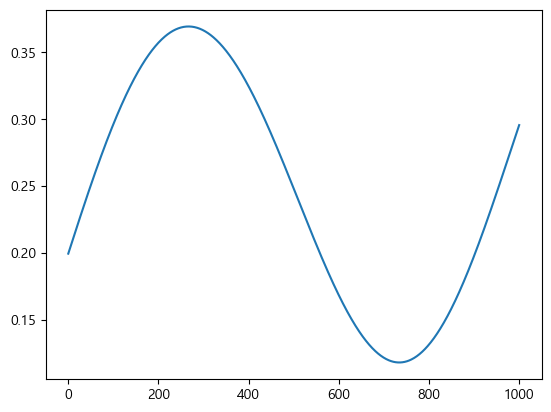

In [108]:
plt.plot(y_pred_pinn[:,0])

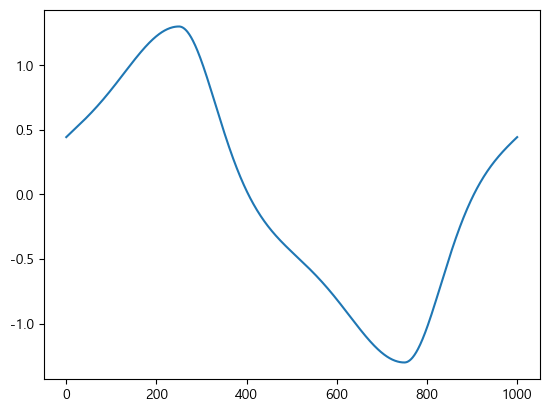

In [109]:
plt.plot(y_te)

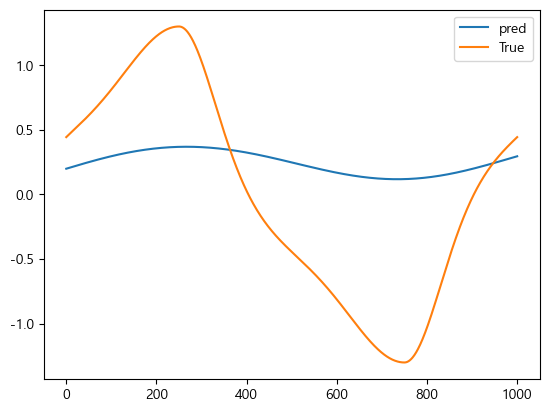

In [110]:
plt.plot(y_pred_pinn[:,0], label = 'pred')
plt.plot(y_te, label = 'True')
plt.legend()
plt.show()

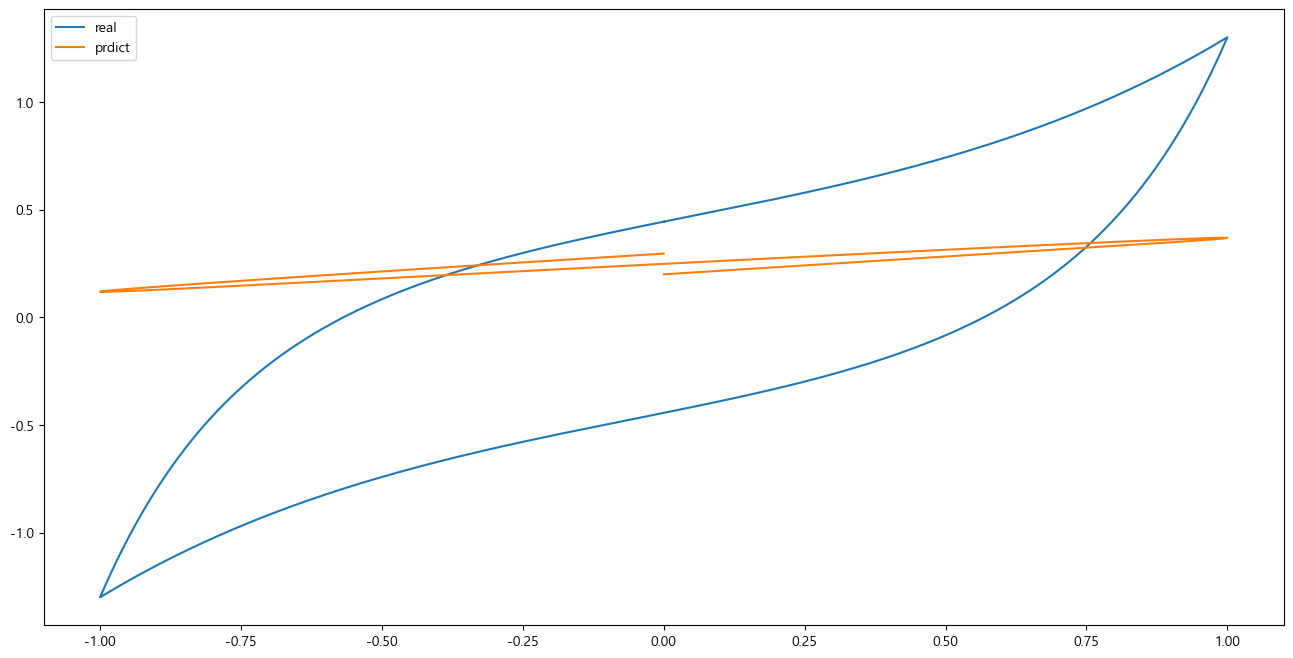

In [111]:
plt.figure(figsize=(16,8))
plt.plot(x.iloc[2000:,0], y.iloc[2000:], label = 'real')
plt.plot(x.iloc[2000:,0], y_pred_pinn[:,0], label = 'prdict')
plt.legend()
plt.show()